In [10]:
%load_ext nb_black
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import jax.numpy as jnp
import jax
from jax import vmap
from jax.scipy.special import xlogy

jax.config.update("jax_enable_x64", True)
import scipy.linalg

from collections import defaultdict
import gzip

from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from ete3 import Tree
from datetime import datetime, MINYEAR

from vbsky.fasta import SeqData
from vbsky.bdsky import _lognorm_logpdf
from vbsky.prob import VF
from vbsky.prob.distribution import PointMass
from vbsky.prob.transform import (
    Transform,
    Compose,
    Affine,
    Blockwise,
    Positive,
    ZeroOne,
    DiagonalAffine,
    Householder,
    Shift,
    Scale,
    Bounded,
    Exp,
    Softplus,
    Concat,
)
from vbsky.prob.distribution import Constant
from vbsky.prob import arf

from vbsky.plot import *
from vbsky.substitution import JC69

pos = Compose(DiagonalAffine, Exp)
plus = Compose(DiagonalAffine, Positive)
z1 = Compose(DiagonalAffine, ZeroOne)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_18451/668997703.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

## Import Simulated Data

In [11]:
from Bio import SeqIO, AlignIO, Phylo
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from datetime import datetime, MINYEAR, timedelta

<IPython.core.display.Javascript object>

In [12]:
# import sh

# scenarios = ["constant", "decrease", "increase", "zigzag"]
# for s in scenarios:
#     for i in range(1, 11):
#         snp_dists = sh.Command("snp-dists")
#         try:
#             with open(f"sims/{s}/tabs/sim{i}.tsv", "w") as tsv:
#                 tsv.write(str(snp_dists("-b", f"sims/{s}/seqs/fasta/sim{i}.fa")))
#         except sh.ErrorReturnCode_2 as e:
#             print(e.stderr.decode())

<IPython.core.display.Javascript object>

## Set up Priors

In [13]:
def _params_prior_loglik(params):
    ll = 0
    tau = {"R": params["precision_R"][0]}
    ll += jax.scipy.stats.gamma.logpdf(tau["R"], a=0.001, scale=1 / 0.001)

    mus = [0, -1]
    sigmas = [1, 0.25]
    for i, k in enumerate(["R", "origin"]):
        log_rate = jnp.log(params[k])
        ll += _lognorm_logpdf(log_rate, mu=mus[i], sigma=sigmas[i]).sum()

    for k in ["R"]:
        log_rate = jnp.log(params[k])
        if k in ["R", "delta", "s"]:
            ll -= (tau[k] / 2) * (jnp.diff(log_rate) ** 2).sum()
            m = len(log_rate)
            ll += xlogy((m - 1) / 2, tau[k] / (2 * jnp.pi))
    return ll


def default_flows(data, m, rate):

    local_flows = [
        {"proportions": Transform(td.n - 2, z1), "root_proportion": Transform(1, z1)}
        for td in data.tds
    ]

    global_flows = VF(
        origin=Transform(1, pos),
        origin_start=Constant(data.earliest),
        #     delta=Transform(m, pos),
        delta=Constant(np.repeat(4.0, m)),
        R=Transform(m, pos),
        rho_m=Constant(0),
        #     s=Transform(m, z1),
        s=Constant(np.repeat(0.25, m)),
        precision_R=Transform(1, pos),
        clock_rate=Constant(1.0),
    )
    return global_flows, local_flows

<IPython.core.display.Javascript object>

In [15]:
fasta = {}
data = {}

scenarios = ["constant", "decrease", "increase", "zigzag"]
# scenarios = ["constant"]

for s in scenarios:
    for z in range(1, 11):
        fasta[(s, z)] = AlignIO.read(f"sims/{s}/seqs/fasta/sim{z}.fa", format="fasta")
        names = []
        dates = []
        for x in fasta[(s, z)]:
            desc = x.description.split("_")
            date = float(desc[1])
            names.append(desc[0])
            dates.append(date)
        data[(s, z)] = SeqData(fasta[(s, z)], names=names, dates=dates)

<IPython.core.display.Javascript object>

In [16]:
min_d = defaultdict(lambda: float("inf"))
max_d = defaultdict(lambda: 0.0)
for k, v in data.items():
    if min_d[k[0]] > v.n:
        min_d[k[0]] = v.n
    if max_d[k[0]] < v.n:
        max_d[k[0]] = v.n

<IPython.core.display.Javascript object>

In [17]:
min_d

defaultdict(<function __main__.<lambda>()>,
            {'constant': 175, 'decrease': 117, 'increase': 124, 'zigzag': 161})

<IPython.core.display.Javascript object>

In [18]:
max_d

defaultdict(<function __main__.<lambda>()>,
            {'constant': 1553,
             'decrease': 590,
             'increase': 1075,
             'zigzag': 1852})

<IPython.core.display.Javascript object>

In [19]:
n_tips = 100
temp_folder = "covid/temp"
tree_path = "covid/temp/subsample.trees"
audacity = False
stratified = False
stratify_by = None

for k, v in data.items():
    n_trees = min(int(np.ceil(v.n / n_tips)), 50)
    v.prep_data(
        n_tips,
        n_trees,
        temp_folder,
        tree_path,
        audacity=audacity,
        stratified=stratified,
    )

Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.46it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.71it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.47it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.80it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.14it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.73it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.37it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.48it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.78it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.66it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.28it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.90it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.22it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.57it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.89it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.77it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.23it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.79it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.59it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.27it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.60it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.32it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.93it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.75it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.66it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.21it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.72it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.68it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.85it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.63it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.84it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.86it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.92it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.62it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.77it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.10it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.38it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.79it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.45it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.71it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.04it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.44it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.76it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.42it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.00it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.74it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.10it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.67it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.77it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.37it/s]

Writing phylo trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]

Readying tip data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  2.80it/s]

Writing phylo trees
Processing trees



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.75it/s]


Readying tip data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.53it/s]


<IPython.core.display.Javascript object>

In [20]:
rate = 1.0
m = 10

for k, v in data.items():
    global_flows, local_flows = default_flows(v, m, rate)
    v.setup_flows(global_flows, local_flows)

rng = jax.random.PRNGKey(6)
res = {}
n_iter = 30
threshold = 0.000001
step_size = 1.0
for k, v in data.items():
    res[k] = v.loop(
        _params_prior_loglik,
        rng,
        n_iter=n_iter,
        step_size=step_size,
        threshold=threshold,
        Q=JC69(),
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:32<00:00,  1.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 570/570 [02:35<00:00,  3.66it/s]


<IPython.core.display.Javascript object>

## Visualize Posteriors

In [23]:
from scipy.interpolate import interp1d
from vbsky.plot import *


def plot_run(ax, i, ps):
    posteriors, earliest, end, _, _, _ = tups[i]
    top = (posteriors["origin"] + earliest)[:, 0]

    x0 = np.linspace(end - np.max(posteriors["origin"]) - earliest, end, 100)
    y0 = []

    for x, y in zip(top, posteriors[k]):
        t = (end - np.linspace(0, x, m + 1))[::-1]
        y0.append(interp1d(t[1:], y, kind="nearest", fill_value="extrapolate")(x0))
    q25, q50, q75 = np.quantile(np.array(y0), q=[0.025, 0.5, 0.975], axis=0)
    # q50 = np.mean(y0, axis=0)
    ax.plot(x0, q50, label=i)
    ax.fill_between(x0, q25, q75, alpha=0.1)
    # plt.xlim(reversed(plt.xlim()))
    # ax.legend()

<IPython.core.display.Javascript object>

In [25]:
def median_median(res, data, ax, m, scenario, n):
    q25s = []
    q50s = []
    q75s = []

    all_coal_times = []
    for i in range(1, n + 1):
        start, top, end, x0 = plot_helper(res[(scenario, i)], data[(scenario, i)], 100)
        y0 = []

        for x1, x2, y in zip(start, top, res[(scenario, i)].global_posteriors["R"]):
            intervals = np.linspace(x1, x2, m + 1)
            t = (end - intervals)[::-1]
            y0.append(
                # interp1d(t[1:], y, kind="nearest", fill_value="extrapolate")(x0)
                interp1d(t[1:], y, kind="nearest", bounds_error=False)(x0)
            )
        q25, q50, q75 = np.nanquantile(np.array(y0), q=[0.025, 0.5, 0.975], axis=0)
        q25s.append(q25)
        q50s.append(q50)
        q75s.append(q75)

    #     x0 = np.linspace(-0.25, 4, 100)
    ax.plot(x0, np.nanmedian(np.array(q50s), axis=0), label=i)
    ax.fill_between(
        x0,
        np.nanmedian(np.array(q25s), axis=0),
        np.nanmedian(np.array(q75s), axis=0),
        alpha=0.1,
    )

<IPython.core.display.Javascript object>

/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_

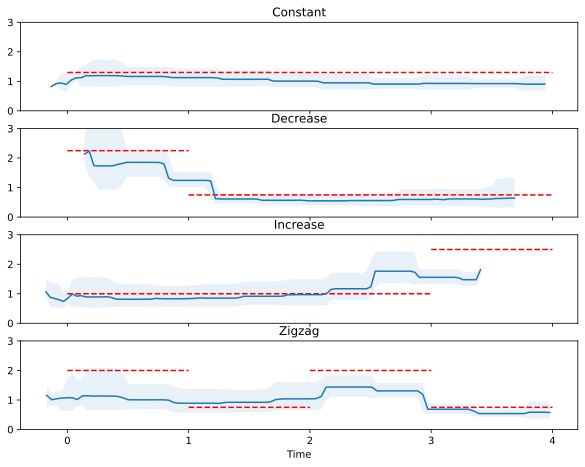

<IPython.core.display.Javascript object>

In [26]:
fig, axs = plt.subplots(4, sharex=True)
median_median(res, data, axs[0], 10, "constant", 10)
axs[0].hlines(1.3, 0, 4, colors="r", linestyles="dashed")
axs[0].set_title("Constant")

median_median(res, data, axs[1], 10, "decrease", 10)
axs[1].hlines(2.25, 0, 1, colors="r", linestyles="dashed")
axs[1].hlines(0.75, 1, 4, colors="r", linestyles="dashed")
axs[1].set_title("Decrease")

median_median(res, data, axs[2], 10, "increase", 10)
axs[2].hlines(1, 0, 3, colors="r", linestyles="dashed")
axs[2].hlines(2.5, 3, 4, colors="r", linestyles="dashed")
axs[2].set_title("Increase")

median_median(res, data, axs[3], 10, "zigzag", 10)
axs[3].hlines(2, 0, 1, colors="r", linestyles="dashed")
axs[3].hlines(0.75, 1, 2, colors="r", linestyles="dashed")
axs[3].hlines(2, 2, 3, colors="r", linestyles="dashed")
axs[3].hlines(0.75, 3, 4, colors="r", linestyles="dashed")
axs[3].set_xlabel("Time")
axs[3].set_title("Zigzag")

fig.set_size_inches(10, 7.5)

for ax in axs:
    ax.set_ylim(0, 3)

fig.savefig("sims/figures/vbsky.pdf", format="pdf")